In [ ]:
!unzip data.zip

Number of used sensors:  9


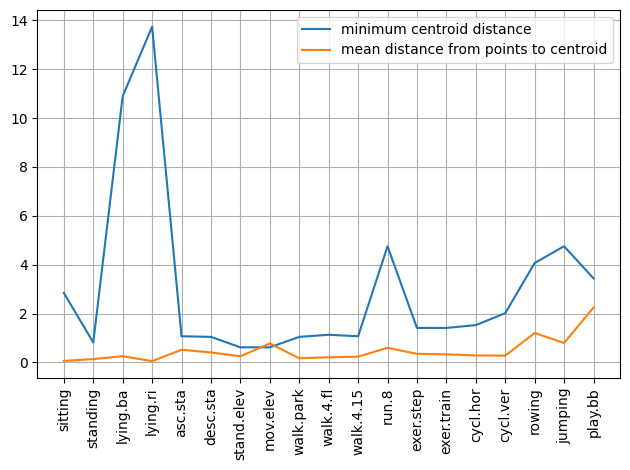

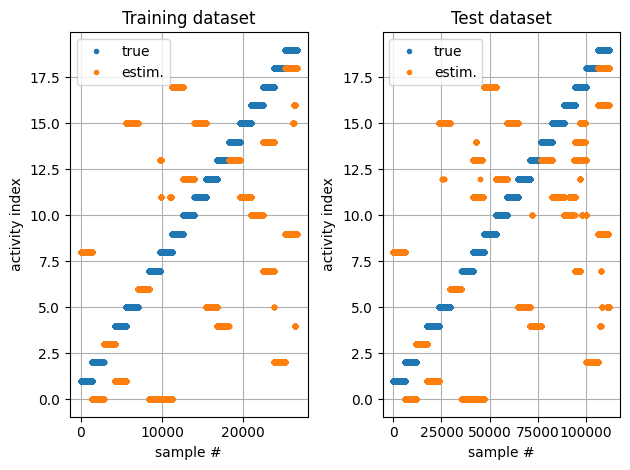

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

cm = plt.get_cmap('gist_rainbow')
line_styles=['solid','dashed','dotted']
#pd.set_option('display.precision', 3)
#%%
def generateDF(filedir,colnames,sensors,patients,activities,slices):
    # get the data from files for the selected patients
    # and selected activities
    # concatenate all the slices
    # generate a pandas dataframe with an added column: activity
    x=pd.DataFrame()
    for pat in patients:
        for a in activities:
            subdir='a'+f"{a:02d}"+'/p'+str(pat)+'/'
            for s in slices:
                filename=filedir+subdir+'s'+f"{s:02d}"+'.txt'
                #print(filename)
                x1=pd.read_csv(filename,usecols=sensors,names=colnames)
                x1['activity']=a*np.ones((x1.shape[0],),dtype=int)
                x=pd.concat([x,x1], axis=0, join='outer', ignore_index=True,
                            keys=None, levels=None, names=None, verify_integrity=False,
                            sort=False, copy=True)
    return x
def genFeatures(x,N):
    # the input is the output of generateDF (including the activity name)
    act=x.activity[0]
    y=x.drop(columns=['activity'])
    cols0=y.columns
    cols1=cols0+'_mean'
    cols2=cols0+'_std'
    y=y.values # get the values of dataFrame x
    Nin=y.shape[0]# number of points in the input dataframe
    Nout=Nin-N # number of valid points in the output dataframe
    yav_m=np.zeros((Nin,y.shape[1]))
    yav_std=np.zeros((Nin,y.shape[1]))
    for k in range(Nout):
        temp=y[k:k+N,:]# get the k-th window with N samples
        yav_m[k+N,:]=np.mean(temp,0)
        yav_std[k+N,:]=np.std(temp,0)
    yav_m=yav_m[N:,:]
    yav_std=yav_std[N:,:]
    outm_df=pd.DataFrame(yav_m,columns=cols1)
    outs_df=pd.DataFrame(yav_std,columns=cols2)
    out_a=pd.DataFrame(act*np.ones((Nout,1)),columns=['activity'])
    out_df=pd.concat([outm_df,outs_df,out_a],axis=1)
    return out_df

#%% initialization
filedir='drive/MyDrive/data/'
sensNames=[
        'T_xacc', 'T_yacc', 'T_zacc',
        'T_xgyro','T_ygyro','T_zgyro',
        'T_xmag', 'T_ymag', 'T_zmag',
        'RA_xacc', 'RA_yacc', 'RA_zacc',
        'RA_xgyro','RA_ygyro','RA_zgyro',
        'RA_xmag', 'RA_ymag', 'RA_zmag',
        'LA_xacc', 'LA_yacc', 'LA_zacc',
        'LA_xgyro','LA_ygyro','LA_zgyro',
        'LA_xmag', 'LA_ymag', 'LA_zmag',
        'RL_xacc', 'RL_yacc', 'RL_zacc',
        'RL_xgyro','RL_ygyro','RL_zgyro',
        'RL_xmag', 'RL_ymag', 'RL_zmag',
        'LL_xacc', 'LL_yacc', 'LL_zacc',
        'LL_xgyro','LL_ygyro','LL_zgyro',
        'LL_xmag', 'LL_ymag', 'LL_zmag']
actNames=[
    'sitting',  # 1
    'standing', # 2
    'lying on back',# 3
    'lying on right side', # 4
    'ascending stairs' , # 5
    'descending stairs', # 6
    'standing in an elevator still', # 7
    'moving around in an elevator', # 8
    'walking in a parking lot', # 9
    'walking on a treadmill with a speed of 4 km/h in flat', # 10
    'walking on a treadmill with a speed of 4 km/h in 15 deg inclined position', # 11
    'running on a treadmill with a speed of 8 km/h', # 12
    'exercising on a stepper', # 13
    'exercising on a cross trainer', # 14
    'cycling on an exercise bike in horizontal positions', # 15
    'cycling on an exercise bike in vertical positions', # 16
    'rowing', # 17
    'jumping', # 18
    'playing basketball' # 19
    ]
actNamesShort=[
    'sitting',  # 1
    'standing', # 2
    'lying.ba', # 3
    'lying.ri', # 4
    'asc.sta' , # 5
    'desc.sta', # 6
    'stand.elev', # 7
    'mov.elev', # 8
    'walk.park', # 9
    'walk.4.fl', # 10
    'walk.4.15', # 11
    'run.8', # 12
    'exer.step', # 13
    'exer.train', # 14
    'cycl.hor', # 15
    'cycl.ver', # 16
    'rowing', # 17
    'jumping', # 18
    'play.bb' # 19
    ]
#%%
plt.close('all')
patients=[5]  # list of selected patients
NAc=19 # total number of activities
activities=list(range(1,20)) #list of indexes of activities to plot
Num_activities=len(activities)
actNamesSub=[actNamesShort[i-1] for i in activities] # short names of the selected activities

ind_acc = [i for i in range(45) if 'acc' in sensNames[i]]# accelerometers
ind_mag = [i for i in range(45) if 'mag' in sensNames[i]]# magnetometers
ind_gyr = [i for i in range(45) if 'gyr' in sensNames[i]]# gyroscopes
sensors1=ind_acc+ind_mag+ind_gyr
sensorsT = [i for i in sensors1 if 'T' in sensNames[i]] # sensors on torso
sensorsLL = [i for i in sensors1 if 'LL' in sensNames[i]]# sensors on left leg
sensorsLA = [i for i in sensors1 if 'LA' in sensNames[i]]# sensors on left arm
sensorsRL = [i for i in sensors1 if 'RL' in sensNames[i]]# sensors on right leg
sensorsRA = [i for i in sensors1 if 'RA' in sensNames[i]]# sensors on right arm
sensors=sensorsT#+sensorsRA+sensorsLL # selected sensors

sensNamesSub=[sensNames[i] for i in sensors] # names of selected sensors
Nslices=12 # number of slices to plot and to train the system
slices=list(range(1,Nslices+1))# first Nslices to plot
NtotSlices=60 #total number of slices
fs=25 # Hz, sampling frequency
samplesPerSecond=fs # samples in one second
samplesPerSlice=fs*5 # samples in each slice
memory = 4*samplesPerSecond
#redNo = True
#%% plot the measurements of each selected sensor for each of the activities
iplot=False
if iplot:
    for i in activities:
        activ=[i]
        x=generateDF(filedir,sensNamesSub,sensors,patients,activ,slices)
        x=genFeatures(x,memory)
        x=x.drop(columns=['activity'])
        sensor_names=list(x.columns)
        data=x.values
        plt.figure(figsize=(6,6))
        time=np.arange(data.shape[0])/fs # set the time axis
        for k in range(len(sensor_names)):
            lines=plt.plot(time,data[:,k],'.',label=sensor_names[k],markersize=1)
            lines[0].set_color(cm(k//3*3/len(sensor_names)))
            lines[0].set_linestyle(line_styles[k%3])
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
        plt.grid()
        plt.xlabel('time (s)')
        plt.tight_layout()
        plt.title(actNames[i-1])
        plt.subplots_adjust(top=0.9)
        plt.savefig('./Plot_'+actNamesSub[i-1]+'.png')
#%% plot centroids and stand. dev. of sensor values
print('Number of used sensors: ',len(sensors))
centroids=np.zeros((NAc,len(sensors)*2))# centroids for all the activities
stdpoints=np.zeros((NAc,len(sensors)*2))# variance in cluster for each sensor
if iplot:
    plt.figure(figsize=(12,6))
for i in range(1,NAc+1):
    activ=[i]
    x=generateDF(filedir,sensNamesSub,sensors,patients,activ,slices)
    x=genFeatures(x,memory)
    x=x.drop(columns=['activity'])
    sensor_names=list(x.columns)
    centroids[i-1,:]=x.mean().values
    stdpoints[i-1]=np.sqrt(x.var().values)
    if iplot:
        plt.subplot(1,2,1)
        lines = plt.plot(centroids[i-1,:],label=actNamesShort[i-1])
        lines[0].set_color(cm(i//3*3/NAc))
        lines[0].set_linestyle(line_styles[i%3])
        plt.subplot(1,2,2)
        lines = plt.plot(stdpoints[i-1,:],label=actNamesShort[i-1])
        lines[0].set_color(cm(i//3*3/NAc))
        lines[0].set_linestyle(line_styles[i%3])
if iplot:
    plt.subplot(1,2,1)
    plt.legend(loc='upper right')
    plt.grid()
    plt.title('Centroids using '+str(len(sensor_names))+' sensors')
    plt.xticks(np.arange(x.shape[1]),list(x.columns),rotation=90)
    plt.subplot(1,2,2)
    plt.legend(loc='upper right')
    plt.grid()
    plt.title('Standard deviation using '+str(len(sensor_names))+' sensors')
    plt.xticks(np.arange(x.shape[1]),list(x.columns),rotation=90)
    plt.tight_layout()

#%%
if iplot:
    plt.figure(figsize=(12,10))
    plt.matshow(centroids,fignum=0)
    plt.gca().xaxis.tick_bottom()
    plt.xticks(np.arange(len(x.columns)), list(x.columns), rotation=90)
    plt.yticks(np.arange(len(actNamesShort)), actNamesShort, rotation=0)
    plt.colorbar()
    plt.title('Mean value for each sensor and activity')
    plt.tight_layout()
    plt.figure(figsize=(12,10))
    plt.matshow(stdpoints,fignum=0)
    plt.gca().xaxis.tick_bottom()
    plt.xticks(np.arange(len(x.columns)), list(x.columns), rotation=90)
    plt.yticks(np.arange(len(actNamesShort)), actNamesShort, rotation=0)
    plt.colorbar()
    plt.title('Stand. dev. for each sensor and activity')
    plt.tight_layout()


#%% distances between centroids
d=np.zeros((NAc,NAc))
for i in range(NAc):
    for j in range(NAc):
        d[i,j]=np.linalg.norm(centroids[i]-centroids[j])
if iplot:
    plt.figure(figsize=(12,10))
    plt.matshow(d,fignum=0)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar()
    plt.xticks(np.arange(NAc),actNamesShort,rotation=90)
    plt.yticks(np.arange(NAc),actNamesShort)
    plt.subplots_adjust(bottom=0.2)
    plt.title('Between-centroids distance')

#%% compare minimum distance between two centroids and mean distance from a cluster point
# and its centroid
dd=d+np.eye(NAc)*1e6# remove zeros on the diagonal (distance of centroid from itself)
dmin=dd.min(axis=0)# find the minimum distance for each centroid
dpoints=np.sqrt(np.sum(stdpoints**2,axis=1))
plt.figure()
plt.plot(dmin,label='minimum centroid distance')
plt.plot(dpoints,label='mean distance from points to centroid')
plt.grid()
plt.xticks(np.arange(NAc),actNamesShort,rotation=90)
plt.legend()
plt.tight_layout()
# if the minimum distance is less than the mean distance, then some points of the cluster are closer
# to another centroid

#%% generate the training and test datasets by concatenating data for each activity
slicesTrain=list(range(1,Nslices+1))# slices for the training part
slicesTest=list(range(Nslices+1,NtotSlices+1))# first for the test part
Ntrain=Nslices*samplesPerSlice
Ntest=(NtotSlices-Nslices)*samplesPerSlice
dataTrain=np.empty((0,len(sensors)*2), float)
dataTest=np.empty((0,len(sensors)*2), float)

labelTrain=np.empty((0,), float)
labelTest=np.empty((0,), float)
for i in range(1,NAc+1):
    activ=[i]
    x=generateDF(filedir,sensNamesSub,sensors,patients,activ,slicesTrain)
    x=genFeatures(x,memory)
    labels=x.activity.values
    x=x.drop(columns=['activity'])
    data=x.values
    dataTrain=np.vstack((dataTrain,data))
    labelTrain=np.hstack((labelTrain,labels))
    x=generateDF(filedir,sensNamesSub,sensors,patients,activ,slicesTest)
    x=genFeatures(x,memory)
    labels=x.activity.values
    x=x.drop(columns=['activity'])
    data=x.values
    dataTest=np.vstack((dataTest,data))
    labelTest=np.hstack((labelTest,labels))
#%% Use K-Means
labsTrue=np.unique(labelTrain)
Nclu=len(labsTrue)
clu=KMeans(n_clusters=Nclu,init='k-means++', n_init=10,
            max_iter=300,tol=0.0001, verbose=0,
            random_state=1, copy_x=True)
clu.fit(dataTrain)

labCluTrain=clu.labels_
labsClu=np.unique(labCluTrain)
labCluTest=clu.predict(dataTest)
#%%
plt.figure()
plt.subplot(1,2,1)
plt.plot(labelTrain,'.',label='true')
plt.plot(labCluTrain,'.',label='estim.')
plt.title('Training dataset')
plt.legend()
plt.grid()
plt.xlabel('sample #')
plt.ylabel('activity index')
plt.subplot(1,2,2)
plt.plot(labelTest,'.',label='true')
plt.plot(labCluTest,'.',label='estim.')
plt.title('Test dataset')
plt.legend()
plt.grid()
plt.xlabel('sample #')
plt.ylabel('activity index')
plt.tight_layout()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

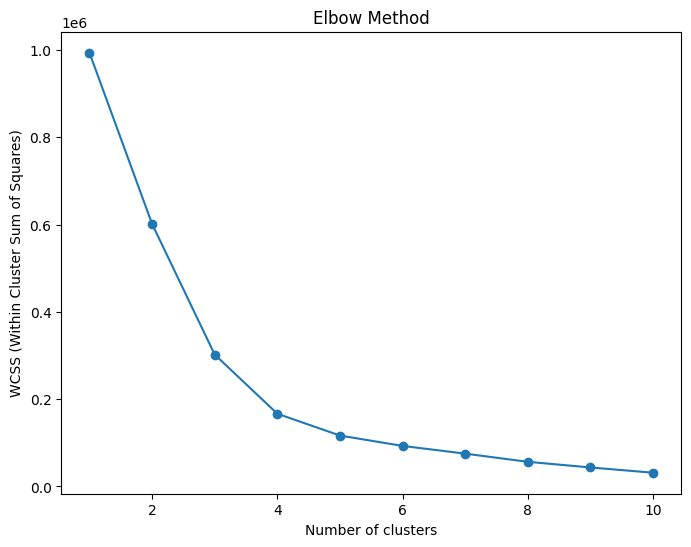

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


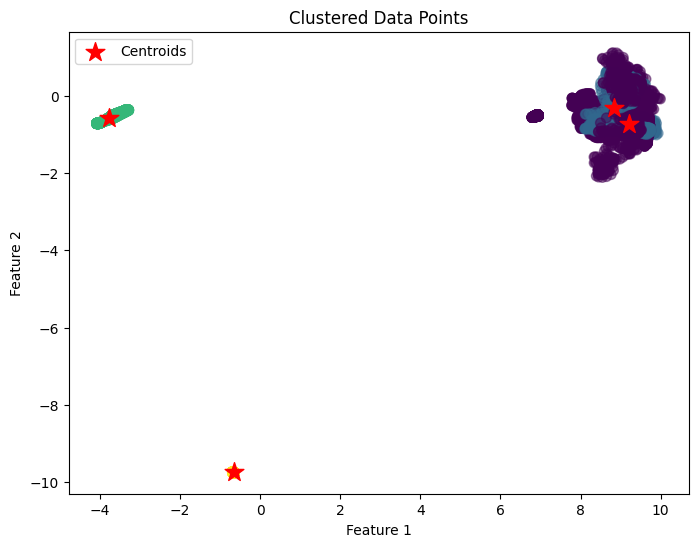

In [3]:
# Using the Elbow Method to find the optimal number of clusters (K)
wcss = []
max_clusters = 10  # Maximum number of clusters to try
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(dataTrain)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.show()

# Using K-Means with the chosen number of clusters
chosen_clusters = 4  # Choose the number of clusters based on the Elbow Method
kmeans = KMeans(n_clusters=chosen_clusters, init='k-means++', random_state=42)
kmeans.fit(dataTrain)

# Plotting clustered data points
# Assuming dataTrain is a 2D array with shape (number of samples, number of features)
plt.figure(figsize=(8, 6))
plt.scatter(dataTrain[:, 0], dataTrain[:, 1], c=kmeans.labels_, cmap='viridis', s=50, alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='*', label='Centroids')
plt.title('Clustered Data Points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


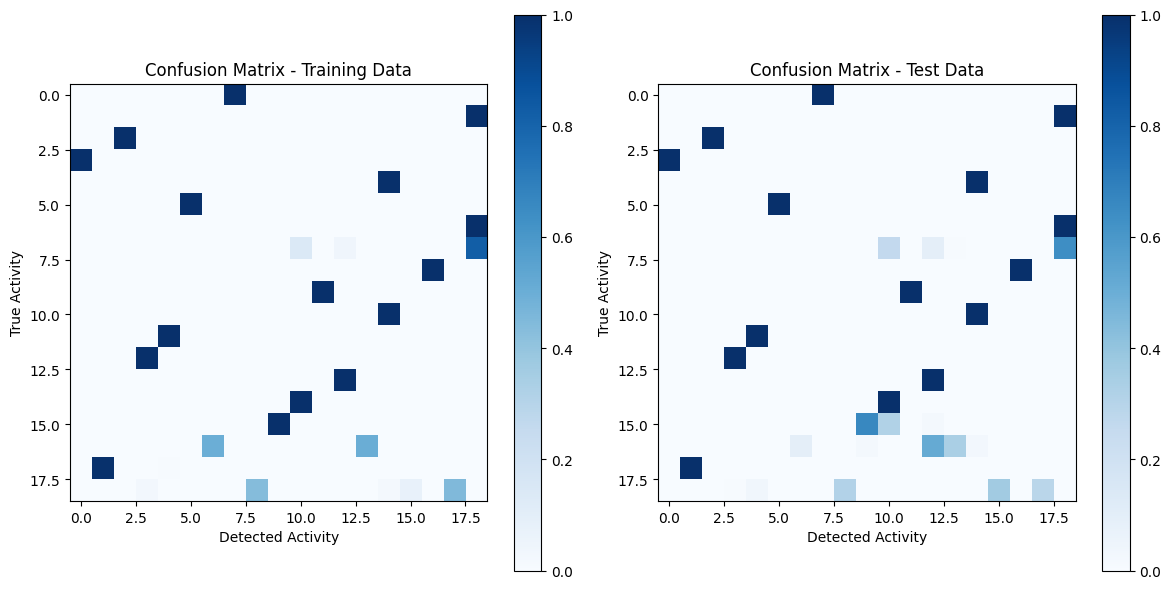

In [4]:

# Compute confusion matrix for training data
conf_matrix_train = np.zeros((len(actNamesShort), len(actNamesShort)))
for true_label, detected_label in zip(labelTrain, labCluTrain):
    conf_matrix_train[int(true_label) - 1][int(detected_label) - 1] += 1

# Normalize confusion matrix for training data to obtain probabilities
conf_matrix_train_norm = conf_matrix_train / conf_matrix_train.sum(axis=1, keepdims=True)

# Compute confusion matrix for test data
conf_matrix_test = np.zeros((len(actNamesShort), len(actNamesShort)))
for true_label, detected_label in zip(labelTest, labCluTest):
    conf_matrix_test[int(true_label) - 1][int(detected_label) - 1] += 1

# Normalize confusion matrix for test data to obtain probabilities
conf_matrix_test_norm = conf_matrix_test / conf_matrix_test.sum(axis=1, keepdims=True)

# Plotting confusion matrix for training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(conf_matrix_train_norm, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Detected Activity')
plt.ylabel('True Activity')
plt.colorbar()

# Plotting confusion matrix for test data
plt.subplot(1, 2, 2)
plt.imshow(conf_matrix_test_norm, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Detected Activity')
plt.ylabel('True Activity')
plt.colorbar()

plt.tight_layout()
plt.show()


In [5]:
# Calculate accuracy for training data
accuracy_train = np.sum(np.diag(conf_matrix_train) / np.sum(conf_matrix_train, axis=1)) / len(actNamesShort)

# Calculate accuracy for test data
accuracy_test = np.sum(np.diag(conf_matrix_test) / np.sum(conf_matrix_test, axis=1)) / len(actNamesShort)

# Display accuracies
print(f"Accuracy - Training Data: {accuracy_train:.2%}")
print(f"Accuracy - Test Data: {accuracy_test:.2%}")


Accuracy - Training Data: 10.53%
Accuracy - Test Data: 10.53%


In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, Nclu)

# Calculate accuracy for each activity
accuracies = []
for i in range(conf_matrix.shape[0]):
    accuracy = conf_matrix[i, i] / np.sum(conf_matrix[i, :])
    accuracies.append(accuracy)

# Find two activities that are mostly confused
max_confusion = np.max(conf_matrix - np.eye(len(conf_matrix)), axis=1)
most_confused_indices = np.argsort(max_confusion)[-2:]  # Indices of the two most confused activities

# Get the corresponding activity names
most_confused_activities = [actNamesShort[i] for i in most_confused_indices]

# Plot accuracies of each activity
plt.figure(figsize=(10, 6))
plt.bar(actNamesShort, accuracies, color='skyblue')
plt.xlabel('Activities')
plt.ylabel('Accuracy')
plt.title('Accuracy of Each Activity')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1 for accuracy percentage
plt.grid(axis='y')
plt.show()

print(f"The two most confused activities are: {most_confused_activities[0]} and {most_confused_activities[1]}")
